### Parte 7: Visualización de salidas

#### 7.1 Importación de los datos

In [19]:
from wrf import (to_np, get_cartopy, latlon_coords, getvar)
from matplotlib.pyplot  import get_cmap
import matplotlib.pyplot as plt
import cartopy.feature as cf
from netCDF4 import Dataset
import cartopy.crs as crs
import tensorflow as tf 
import numpy as np 

path= "../../parches_winscp/bicubic_32_32/190824_16_va"

input_u10   = tf.convert_to_tensor(np.load(f"{path}/norm/u10_input_norm_190824_16_va.npy") ,dtype=tf.float32)
input_v10   = tf.convert_to_tensor(np.load(f"{path}/norm/v10_input_norm_190824_16_va.npy") ,dtype=tf.float32)
target_u10  = tf.convert_to_tensor(np.load(f"{path}/norm/u10_target_norm_190824_16_va.npy"), dtype=tf.float32)
target_v10  = tf.convert_to_tensor(np.load(f"{path}/norm/v10_target_norm_190824_16_va.npy"), dtype=tf.float32)
orog_inp    = tf.convert_to_tensor(np.load(f"{path}/norm/hgt_input_norm_190824_16_va.npy"), dtype=tf.float16)


prop = "_prop_B_" ## Cambiar ##
output_val  = tf.convert_to_tensor(np.load(f"extra/salidas/salidas_190824_16_80_64_0.75{prop}va.npy"),dtype=tf.float32 )
output_u10  = output_val[:,:,:,0]
output_v10  = output_val[:,:,:,1]

print("output_val: ",output_val.shape)
print("target_u10: ",target_u10.shape)
print("target_v10: ",target_v10.shape)

output_val:  (143520, 32, 32, 2)
target_u10:  (143520, 32, 32, 1)
target_v10:  (143520, 32, 32, 1)


#### 7.2 Desnormalización de los datos

In [20]:
import pickle

with open('extra/factores/factores_escala_190824_16.pkl', 'rb') as archivo:
    factores_escala = pickle.load(archivo)

factores_escala

{'u10_input': [-24.035671, 19.812311],
 'u10_target': [-31.29994, 31.842432],
 'v10_input': [-20.810207, 14.965427],
 'v10_target': [-30.851156, 23.74102],
 't2_input': [257.75668, 298.89575],
 'th2_input': [267.9052, 303.7989],
 'psfc_input': [82636.02, 103507.99],
 'pblh_input': [-273.23758, 2129.6934],
 'xland_input': [0.761478, 2.2074287],
 'hgt_input': [-22.215477, 1449.4507],
 'aspect_input': [0.0, 360.0],
 'slope_input': [0.0, 89.29281],
 'EmaxU_input': [-23.877573, 17.691437],
 'EmaxV_input': [-19.628057, 13.7348995],
 'EminU_input': [-17.493675, 23.955181],
 'EminV_input': [-13.671599, 19.655247]}

In [21]:
var_names = ["u10_input", "v10_input", "u10_target", "v10_target", "u10_target", "v10_target"]
var_norms = [input_u10, input_v10, target_u10, target_v10, output_u10, output_v10]
var_og    = []

for name,var in zip(var_names, var_norms):

    array_desnorm = var * (factores_escala[name][1] - factores_escala[name][0]) + factores_escala[name][0]
    var_og.append(array_desnorm)

input_u10  = var_og[0][:,:,:,0]; input_v10  = var_og[1][:,:,:,0]
target_u10 = var_og[2][:,:,:,0]; target_v10 = var_og[3][:,:,:,0]
output_u10 = var_og[4]; output_v10 = var_og[5]
var_norms  = None; var_og = None 

print("out_u10 shape: ", output_u10.shape)
print("inp_u10 shape: ", input_u10.shape)
print("tar_u10 shape: ", target_u10.shape)

out_u10 shape:  (143520, 32, 32)
inp_u10 shape:  (143520, 32, 32)
tar_u10 shape:  (143520, 32, 32)


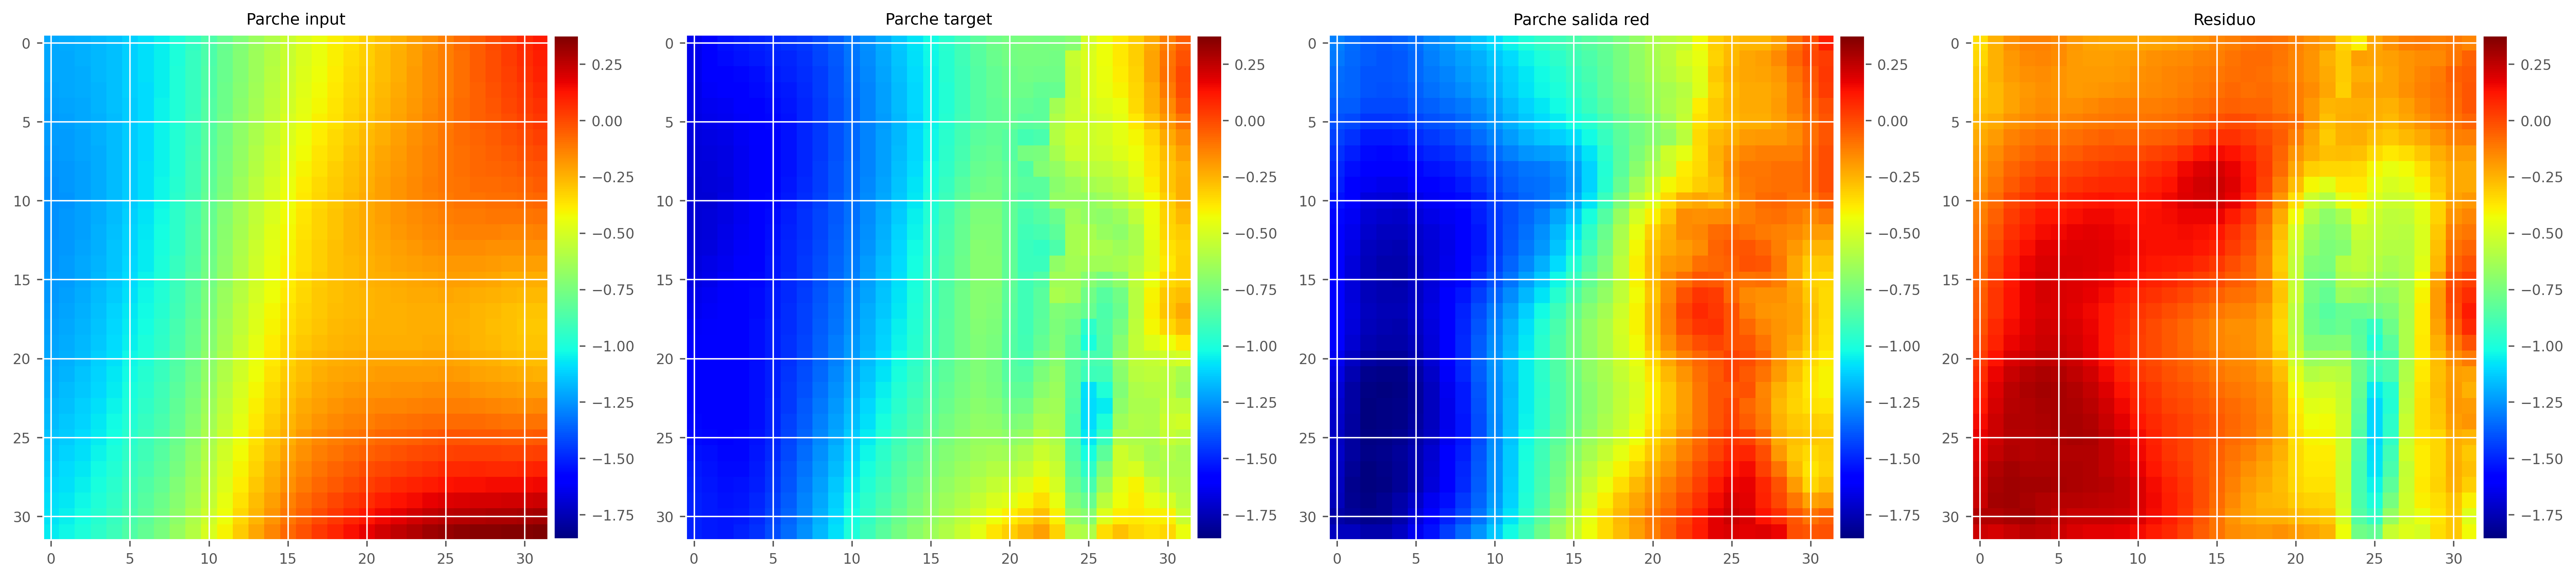

In [22]:
from funciones import output_plot 

i=100005
output_plot(input_u10[i],target_u10[i],output_u10[i], cmap='jet')

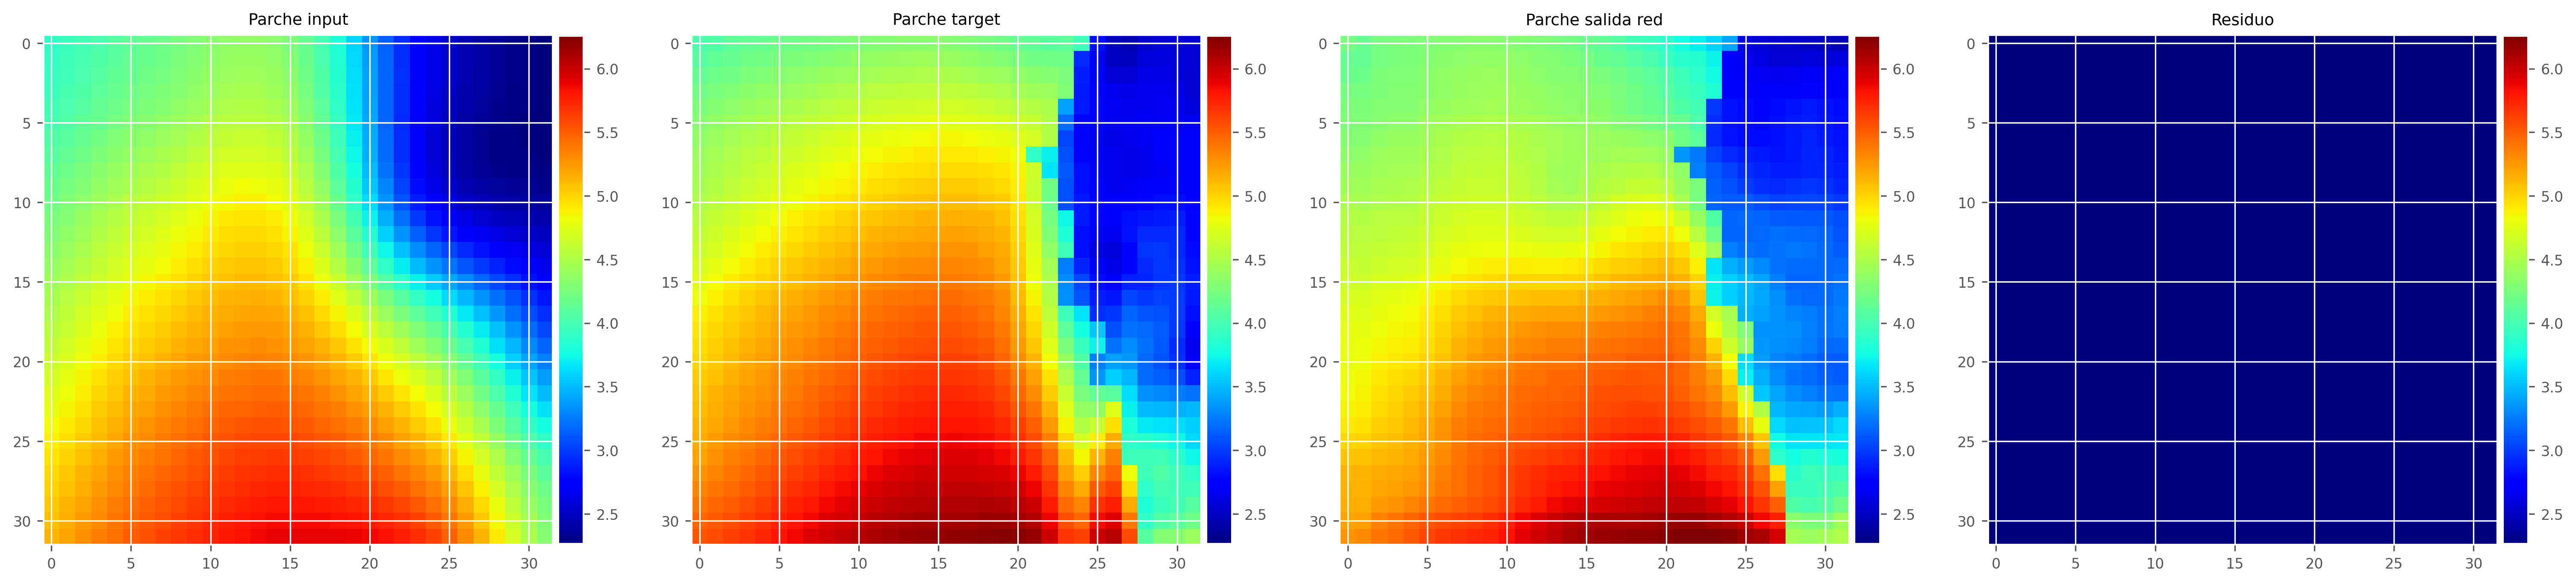

In [23]:
output_plot(input_v10[i],target_v10[i],output_v10[i], cmap='jet')

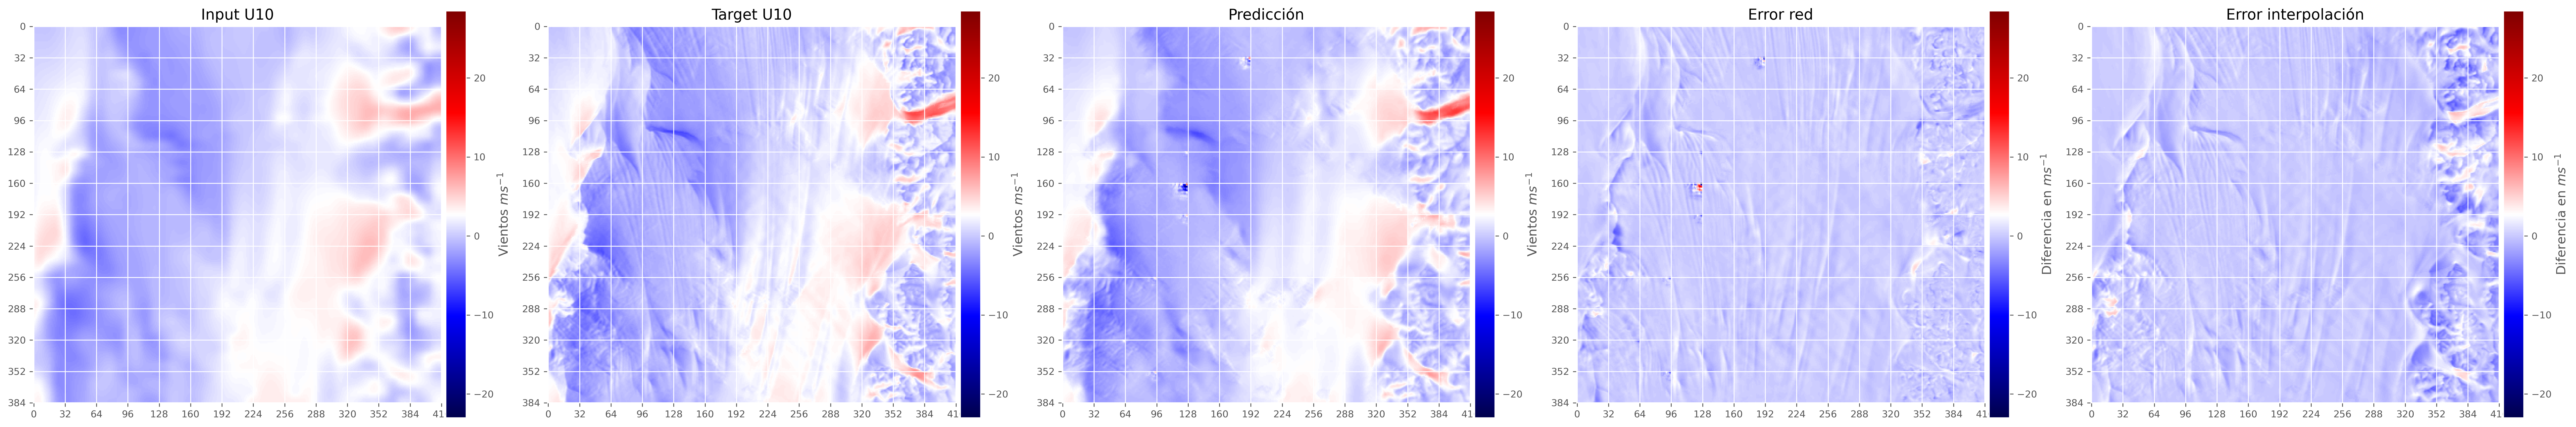

In [24]:
from funciones import determinar_inputs, comparacion_mapas 

inp_u10, tar_u10, fore_u10, res_u10= determinar_inputs(150, input_u10, target_u10, output_u10)
comparacion_mapas(inp_u10, tar_u10, fore_u10, res_u10, var_name="U10", cmap="seismic")

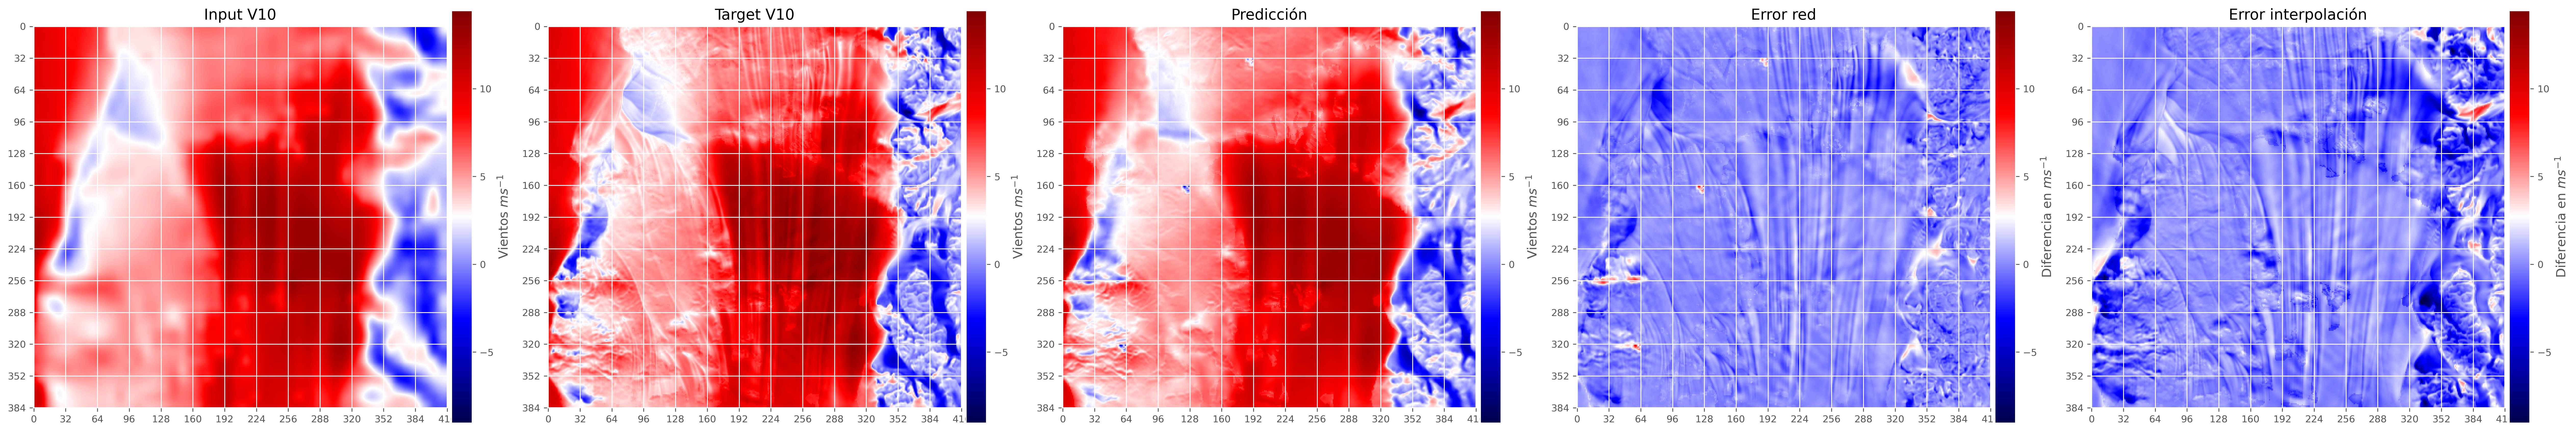

In [25]:
inp_v10, tar_v10, fore_v10, res_v10= determinar_inputs(156, input_v10, target_v10, output_v10)
comparacion_mapas(inp_v10, tar_v10, fore_v10, res_v10, var_name="V10", cmap="seismic")

#### 7.3: Gráficas RMSE punto por punto:
Partimos construyendo los mapas (conjunto de 156 parches)

In [26]:
%%time 

mapas_target_u10=[]; mapas_target_v10=[] 
mapas_fore_u10  =[]; mapas_fore_v10  =[]

for i in range(1,115*8+1):
    _, targ_u10_i, fore_u10_i, _ = determinar_inputs(i, input_u10, target_u10, output_u10)
    _, targ_v10_i, fore_v10_i, _ = determinar_inputs(i, input_v10, target_v10, output_v10)

    mapas_target_u10.append(targ_u10_i)
    mapas_target_v10.append(targ_v10_i)
    mapas_fore_u10.append(fore_u10_i)
    mapas_fore_v10.append(fore_v10_i)

mapas_target_u10 = np.stack(mapas_target_u10, axis=0) 
mapas_target_v10 = np.stack(mapas_target_v10, axis=0)
mapas_fore_u10   = np.stack(mapas_fore_u10, axis=0)
mapas_fore_v10   = np.stack(mapas_fore_v10, axis=0)

print("mapas target u10: ", mapas_target_u10.shape)

mapas target u10:  (920, 384, 416)
CPU times: user 1min 15s, sys: 3.46 s, total: 1min 18s
Wall time: 1min 18s


In [27]:
dif_square_u10 = (mapas_fore_u10 - mapas_target_u10) ** 2
dif_square_v10 = (mapas_fore_v10 - mapas_target_v10) ** 2

mse_puntual_u10 = np.mean(dif_square_u10, axis=0)
mse_puntual_v10 = np.mean(dif_square_v10, axis=0)

rmse_puntual_u10 = np.sqrt( mse_puntual_u10 )
rmse_puntual_v10 = np.sqrt( mse_puntual_v10 )

print(rmse_puntual_u10.shape)  
print(rmse_puntual_v10.shape)  

(384, 416)
(384, 416)


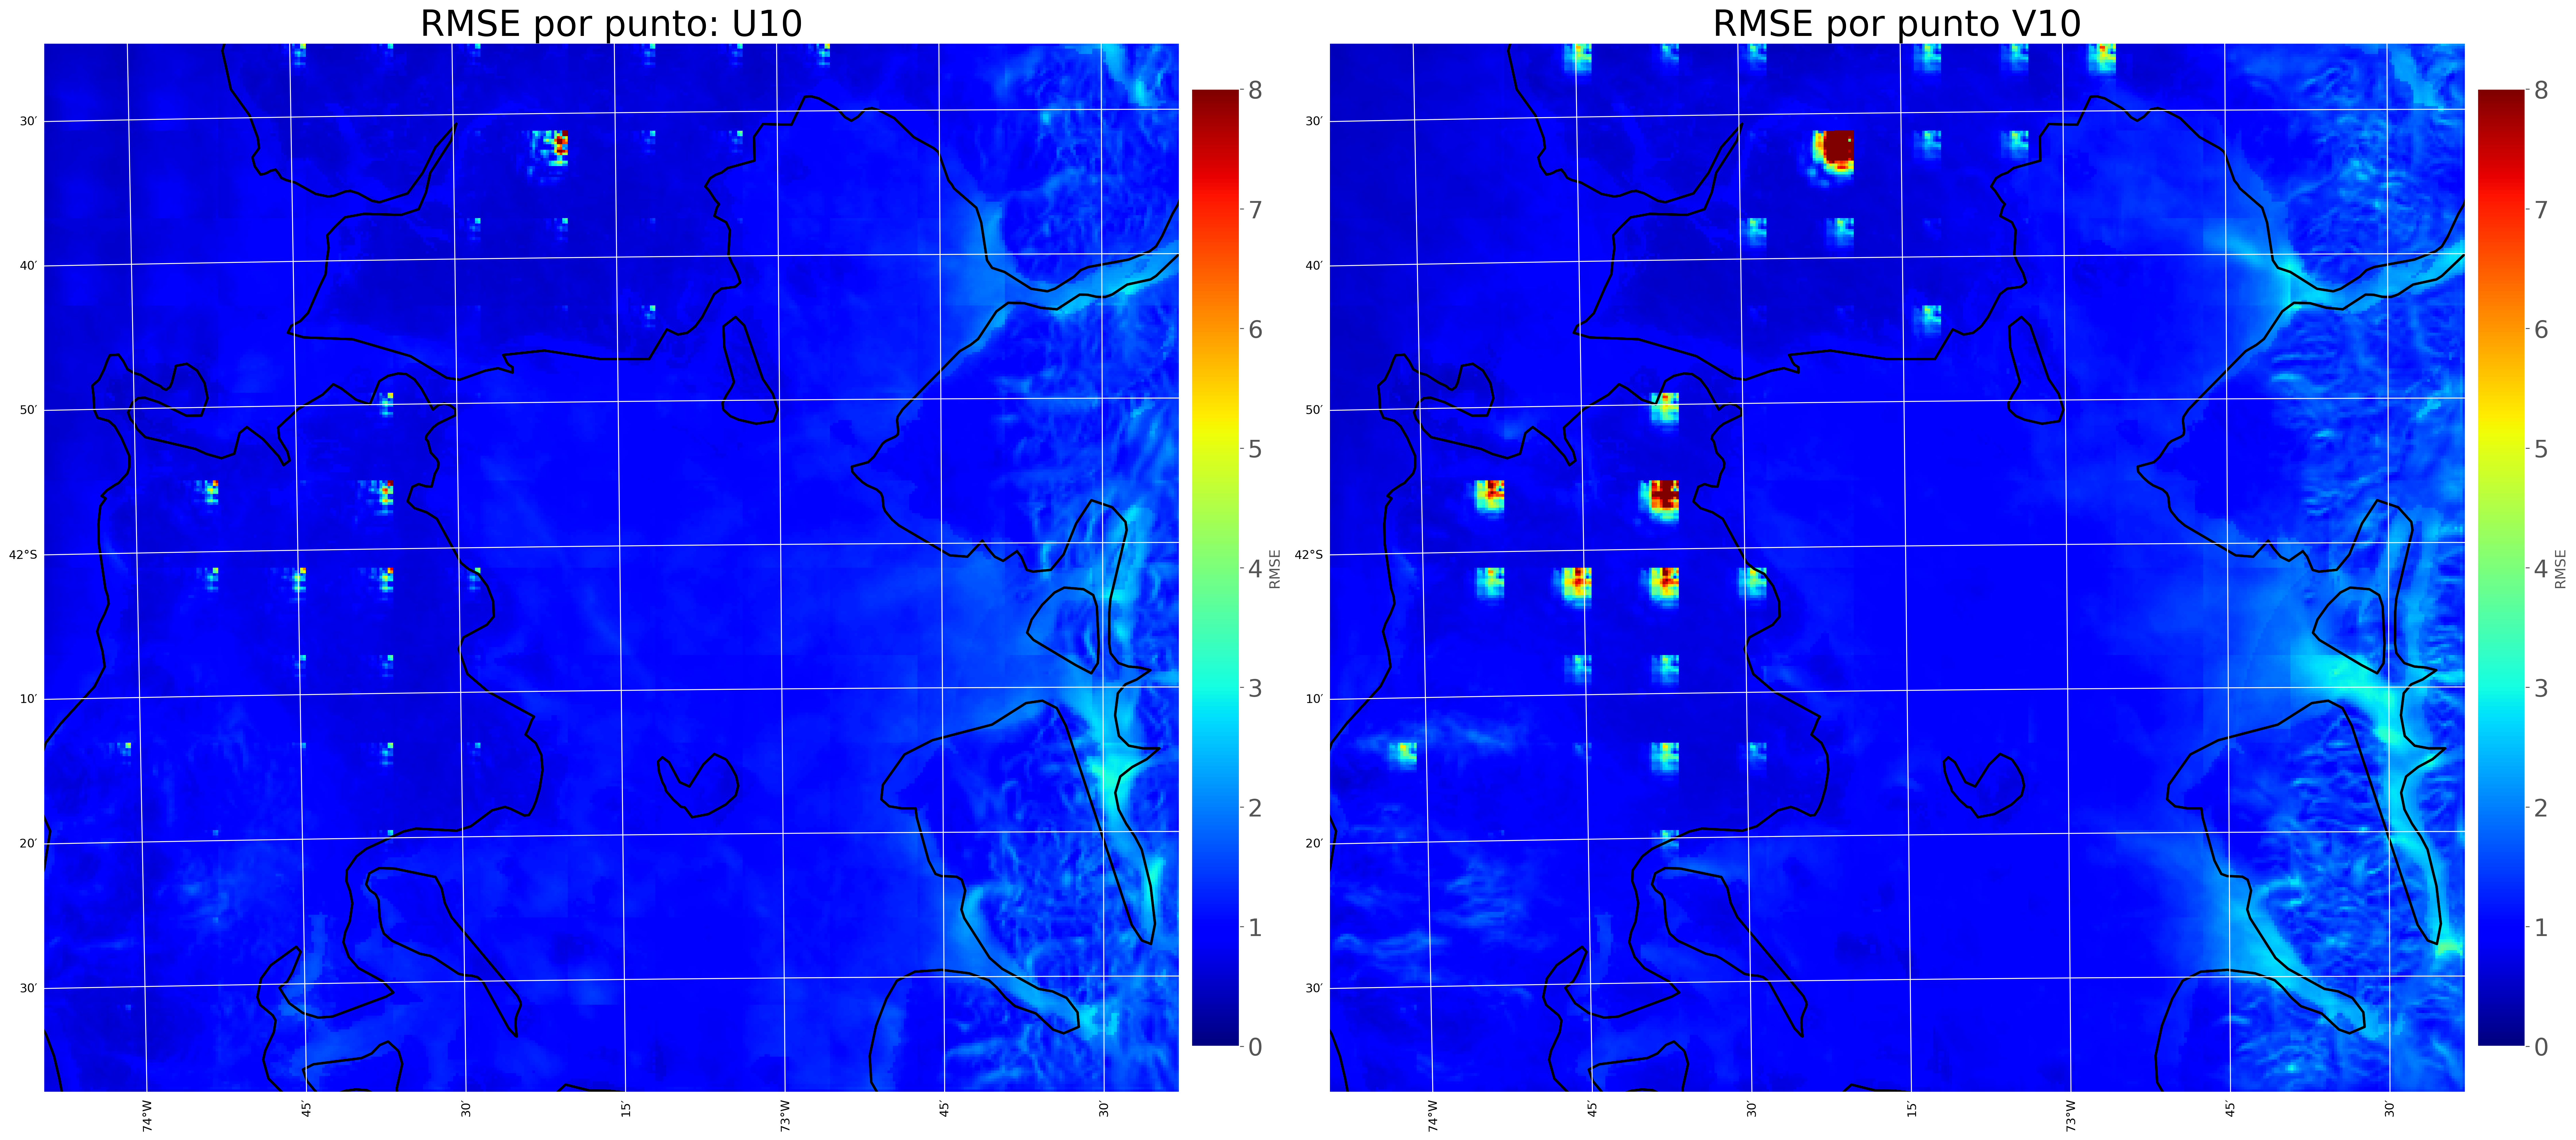

In [28]:
mse_puntual = [rmse_puntual_u10, rmse_puntual_v10]
mse_nombres = ["RMSE por punto: U10", "RMSE por punto V10"]


params = {'xtick.labelsize':20,
          'ytick.labelsize':20} 
              #'figure.figsize': (50,50),
              #'figure.dpi': 400}
              
plt.style.use('ggplot')
plt.rcParams.update(params)

d05 = Dataset("../../files/wrfout_d05_2015-10-25_12%3A00%3A00")
wind_05 = getvar(d05, "HGT") #,  units="m s-1")[0]  #XLAND LANDMASK LAKEMASK #HGT

lats, lons = latlon_coords(wind_05)
cart_proj = get_cartopy(wind_05)

fig, axs = plt.subplots(1, 2, figsize=[30, 20], subplot_kw={'projection': cart_proj})

# Ejemplo de personalización de cada subplot
for i, ax in enumerate(axs.flat):

# Download and add the states and coastlines
    ax.add_feature(cf.COASTLINE, linewidth=2)
    ax.coastlines('10m',linewidth=2)

    var_contourf = ax.pcolormesh(to_np(lons)[6:, 10:], to_np(lats)[6:, 10:], mse_puntual[i],transform=crs.PlateCarree(), 
                                 cmap=get_cmap("jet"),vmin=0,vmax=8) 
    fig.colorbar(var_contourf,ax=ax, fraction=0.04,pad=0.01, label="RMSE")
    

    gridlines=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gridlines.right_labels = False
    gridlines.top_labels = False
    ax.set_title(mse_nombres[i], fontsize=30)

plt.tight_layout()
plt.show()

#### 7.4 Gráficos RMSE para cada cuadrante

In [29]:
mse_per_cuad_u10=[]
mse_per_cuad_v10=[]

simple_check=[]

for i in range(156): #cant cuadrantes

        simple_check.append( target_u10[i::156,:,:].shape[0] ) 

        dif_square_u = ( target_u10[i::156,:,:] - output_u10[i::156,:,:] ) ** 2
        dif_square_v = ( target_v10[i::156,:,:] - output_v10[i::156,:,:] ) ** 2

        rmse_u = np.sqrt ( np.mean(dif_square_u) )
        rmse_v = np.sqrt ( np.mean(dif_square_v) )


        mse_per_cuad_u10.append( (i, rmse_u))
        mse_per_cuad_v10.append( (i, rmse_v))
        

min_rmse_u = min(mse_per_cuad_u10, key=lambda x: x[1])
max_rmse_u = max(mse_per_cuad_u10, key=lambda x: x[1])

min_rmse_v = min(mse_per_cuad_v10, key=lambda x: x[1])
max_rmse_v = max(mse_per_cuad_v10, key=lambda x: x[1])

print("U10 MSE - min: ", min_rmse_u, " - max: ", max_rmse_u)
print("V10 MSE - min: ", min_rmse_v, " - max: ", max_rmse_v)

U10 MSE - min:  (143, 0.580566)  - max:  (51, 2.0451872)
V10 MSE - min:  (143, 0.5314591)  - max:  (135, 5.071813)


In [30]:
rmse_cuad_u10 = np.random.random((12, 13))
rmse_cuad_v10 = np.random.random((12, 13))

for rmse_u10, rmse_v10 in zip(mse_per_cuad_u10, mse_per_cuad_v10):

    row = rmse_u10[0] // rmse_cuad_u10.shape[1]
    col = rmse_u10[0] %  rmse_cuad_u10.shape[1]
    rmse_cuad_u10[row,col] = rmse_u10[1]

    row = rmse_v10[0] // rmse_cuad_v10.shape[1]
    col = rmse_v10[0] %  rmse_cuad_v10.shape[1]
    rmse_cuad_v10[row,col] = rmse_v10[1]


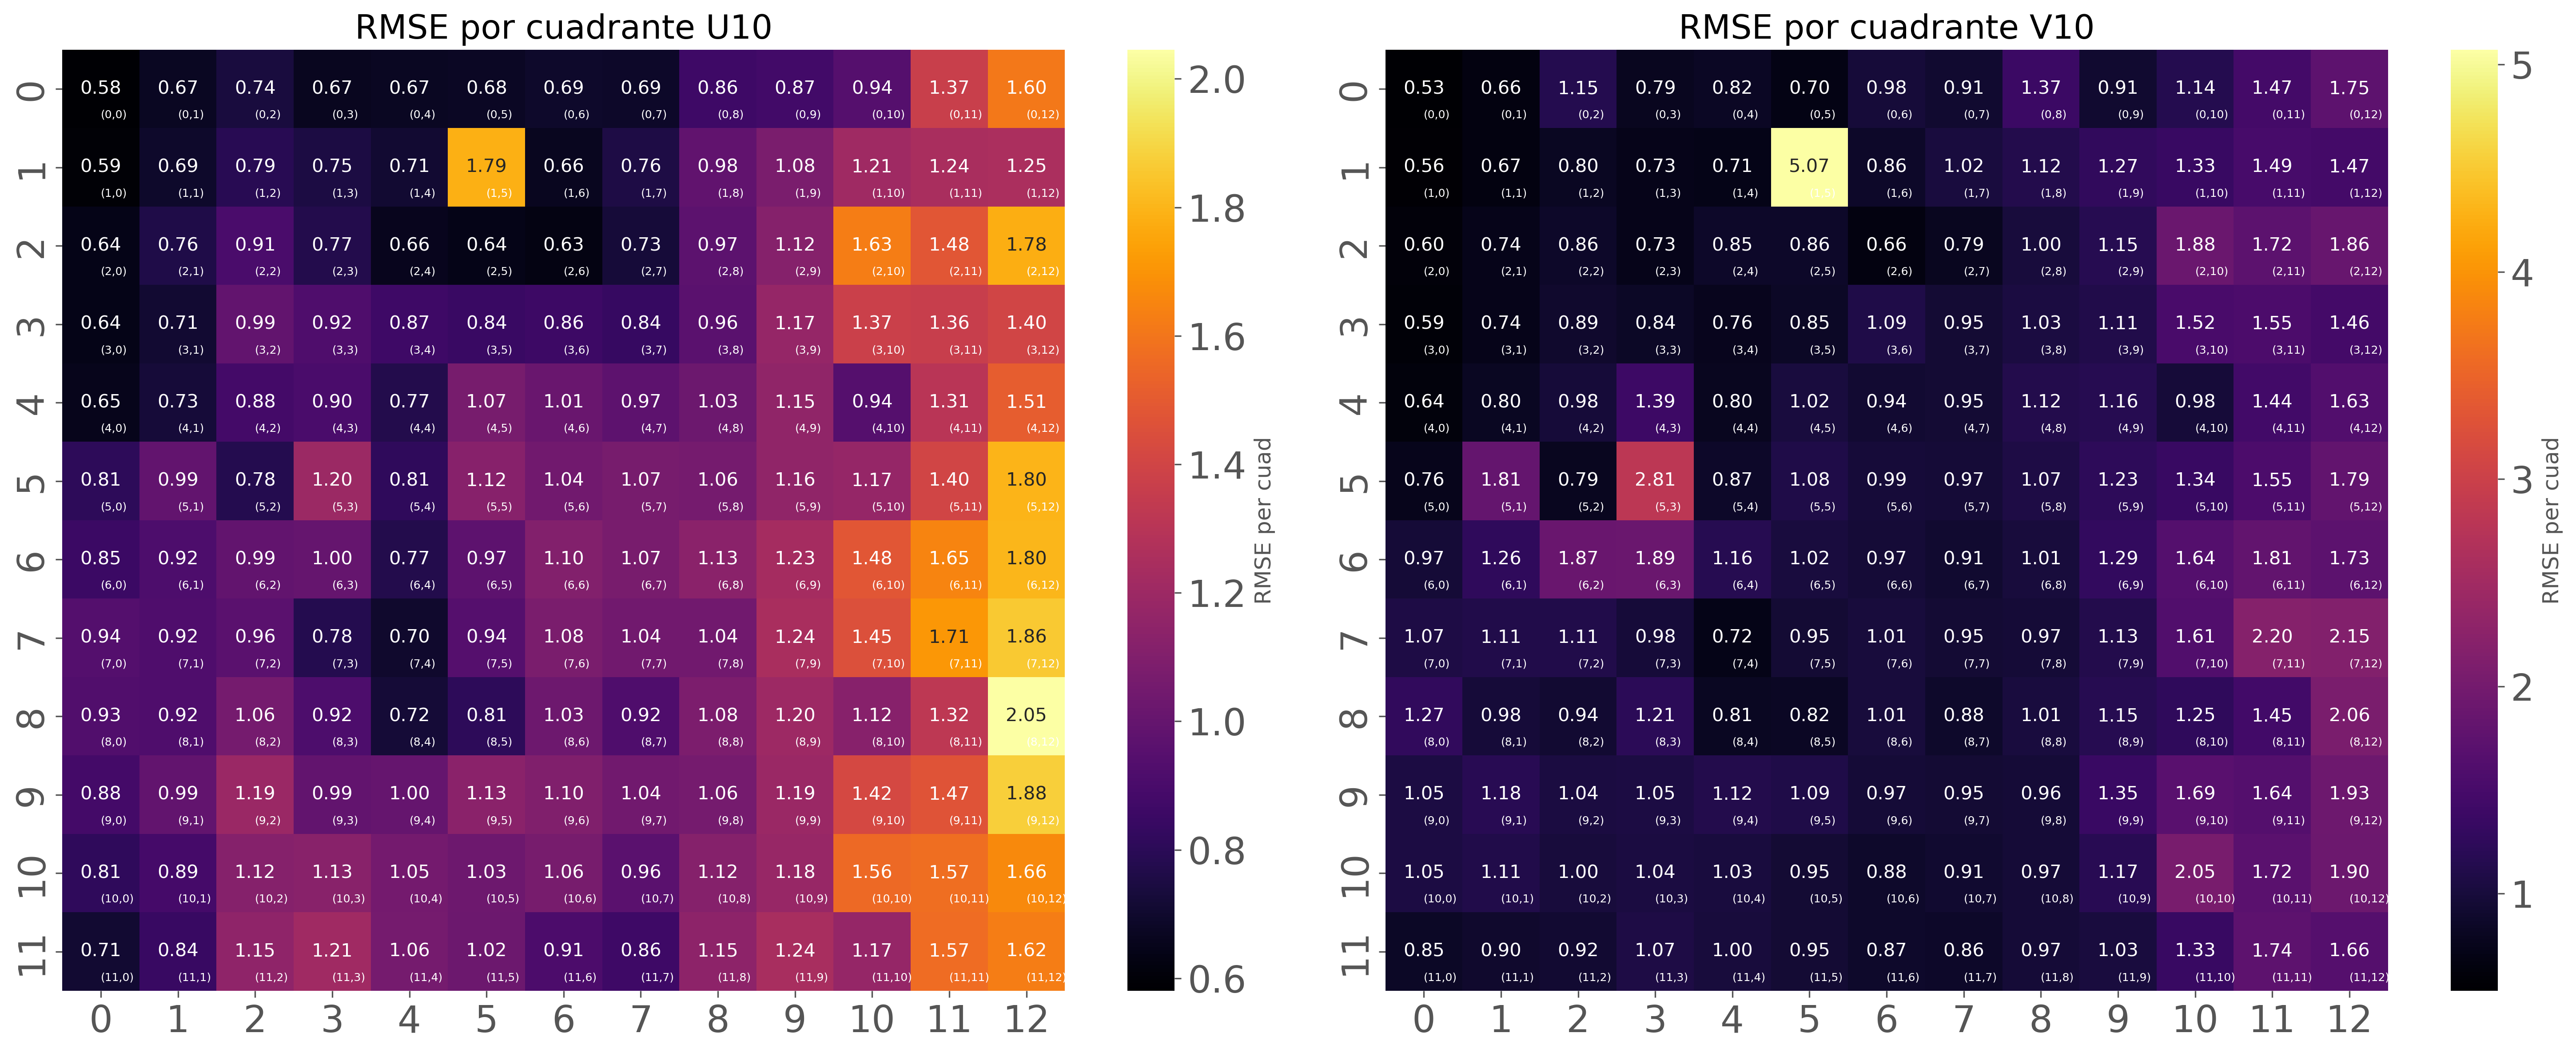

In [31]:
import seaborn as sns

%matplotlib inline

# Crear una figura con dos subgráficas
fig, axes = plt.subplots(1, 2)

# Graficar el primer tensor
sns.heatmap(rmse_cuad_u10[::-1], annot=True, fmt=".2f", cmap="inferno", cbar_kws={'label': 'RMSE per cuad'}, ax=axes[0])
axes[0].set_title("RMSE por cuadrante U10", fontsize="18")

# Añadir posiciones como texto en cada cuadrante del primer tensor
for i in range(rmse_cuad_u10.shape[0]):
    for j in range(rmse_cuad_u10.shape[1]):
        axes[0].text(j + 0.5, i + 0.9, f"({i},{j})", ha='left', va='bottom', fontsize=6, color='white')

# Graficar el segundo tensor
sns.heatmap(rmse_cuad_v10[::-1], annot=True, fmt=".2f", cmap="inferno", cbar_kws={'label': 'RMSE per cuad'}, ax=axes[1])
axes[1].set_title("RMSE por cuadrante V10", fontsize="18")

# Añadir posiciones como texto en cada cuadrante del segundo tensor
for i in range(rmse_cuad_v10.shape[0]):
    for j in range(rmse_cuad_v10.shape[1]):
        axes[1].text(j + 0.5, i + 0.9, f"({i},{j})", ha='left', va='bottom', fontsize=6, color='white')

fig.set_size_inches(20, 8)  # Ajusta el tamaño aquí
plt.tight_layout()
plt.show()

#### 7.5 RMSE para cada caso

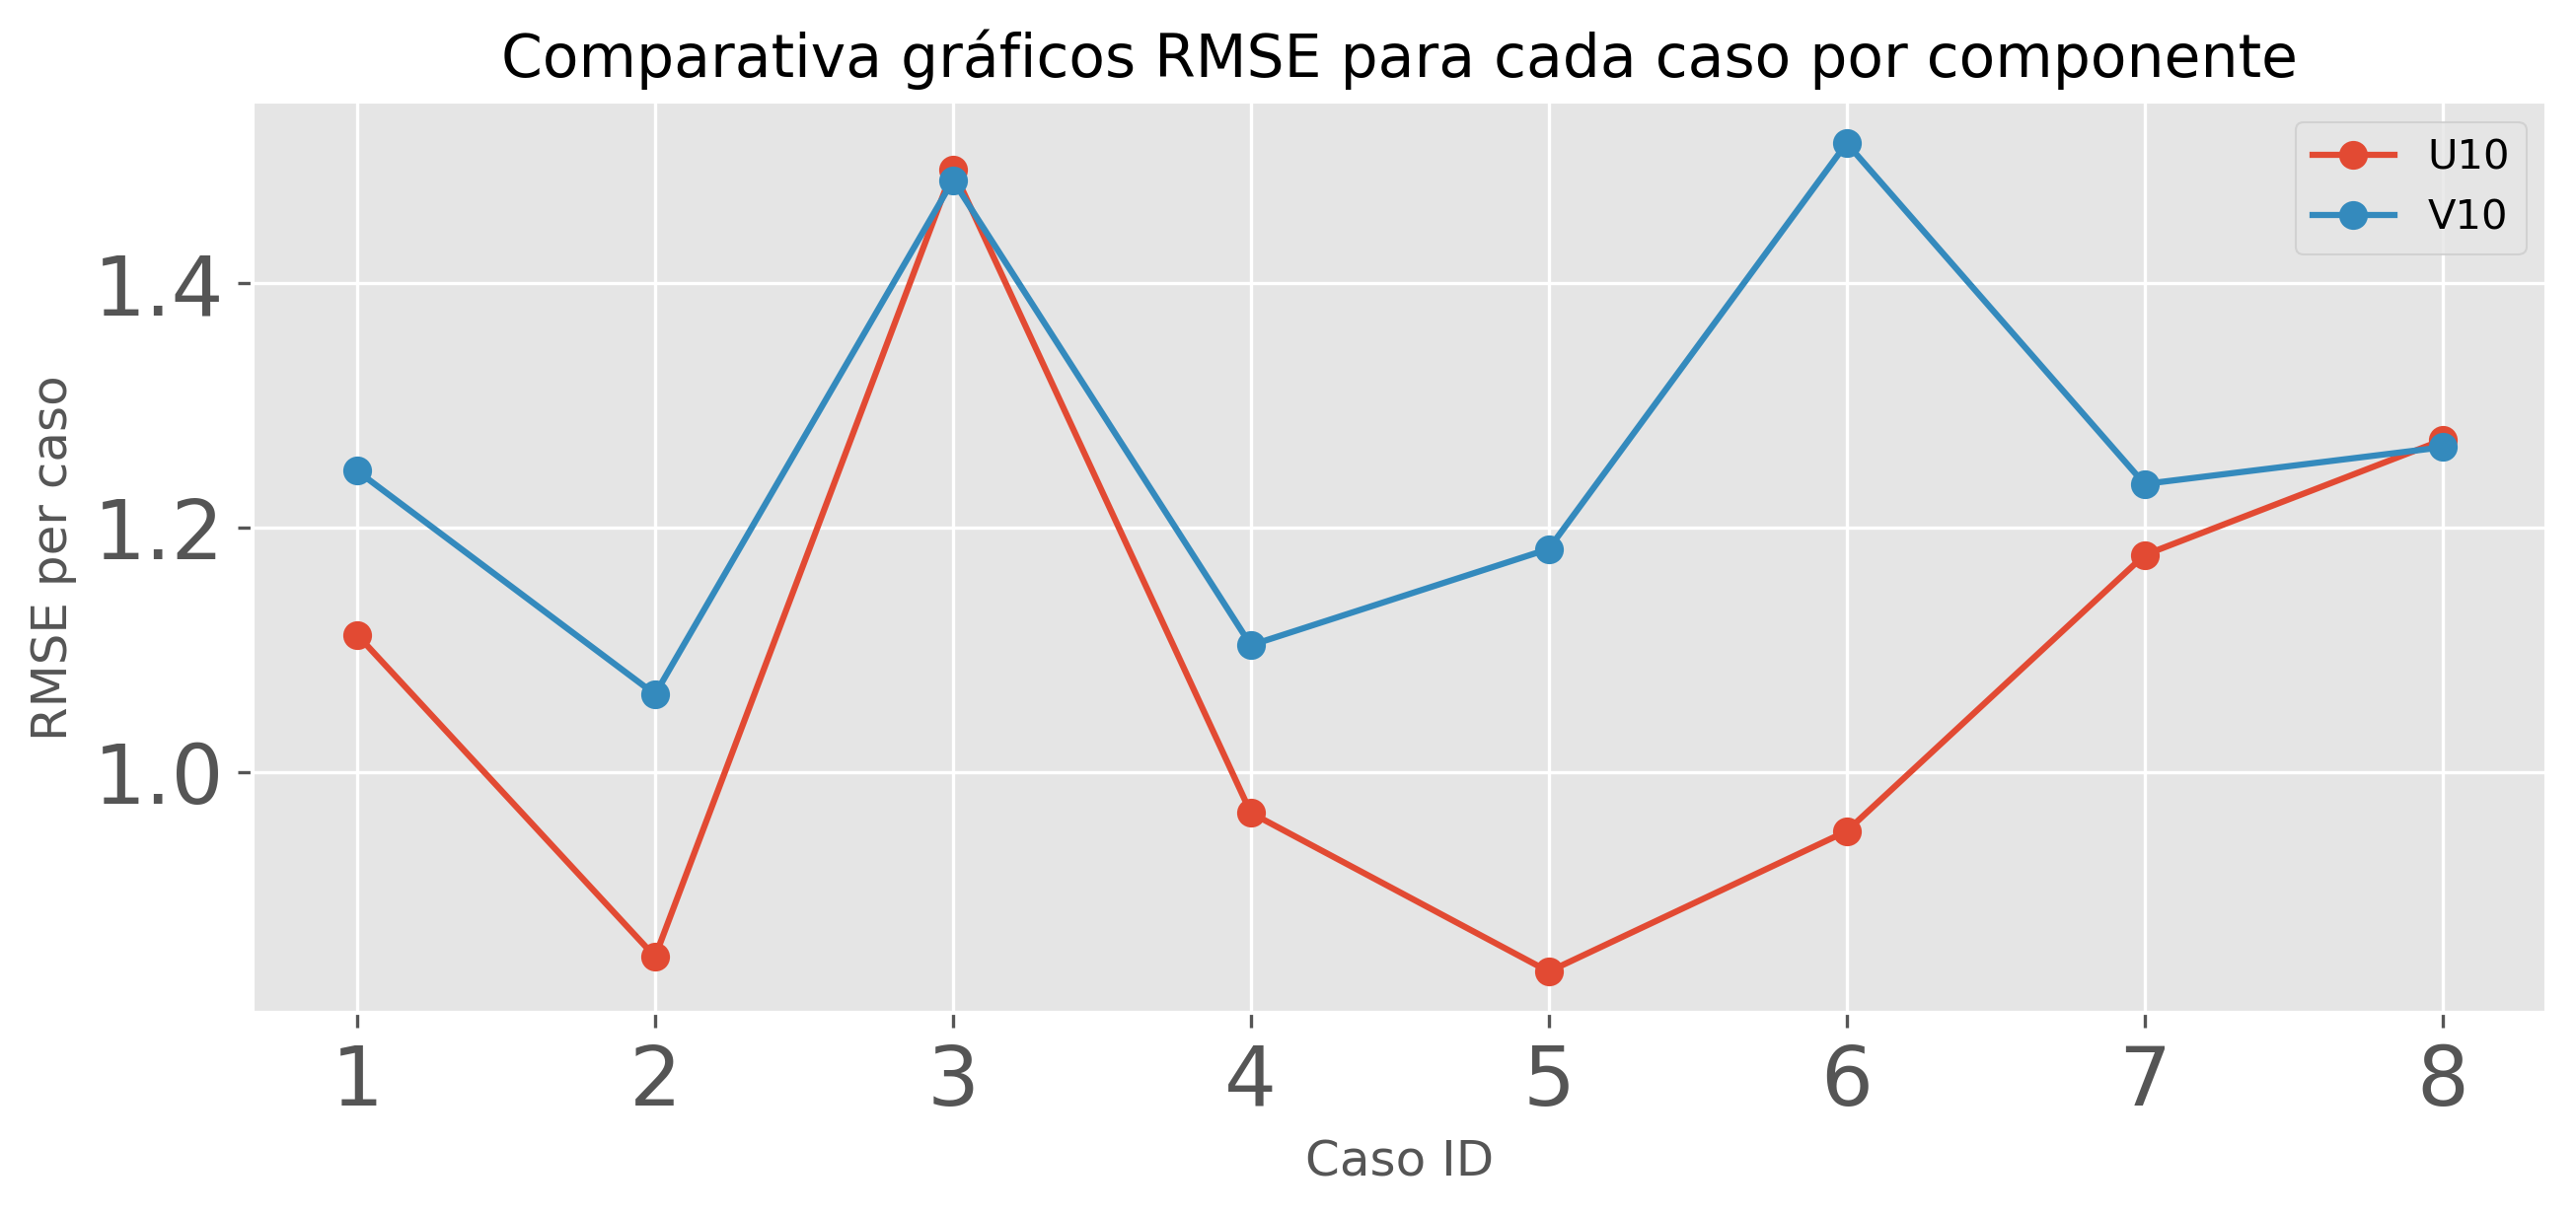

In [32]:
casos_rmse_u = []
casos_rmse_v = []
for i in range(8):

    caso_rmse_u = (mapas_target_u10[115*i : 115*(i+1)] - mapas_fore_u10[115*i : 115*(i+1)])**2
    caso_rmse_v = (mapas_target_v10[115*i : 115*(i+1)] - mapas_fore_v10[115*i : 115*(i+1)])**2

    casos_rmse_u.append( np.sqrt(np.mean(caso_rmse_u)))
    casos_rmse_v.append( np.sqrt(np.mean(caso_rmse_v)))

plt.figure(figsize=(10, 4))
plt.plot(range(1, 9), casos_rmse_u, label='U10', marker='o')
plt.plot(range(1, 9), casos_rmse_v, label='V10', marker='o')
plt.xticks(ticks=range(1, 9), labels=range(1, 9))

plt.xlabel('Caso ID')
plt.ylabel('RMSE per caso')
plt.title('Comparativa gráficos RMSE para cada caso por componente')
plt.legend()
plt.show()

#### 7.6 RMSE para cada hora por caso: 

In [33]:
from sklearn.metrics import root_mean_squared_error


rmse_per_caso_u=[]
rmse_per_caso_v=[]

for i in range (8):
    rmse_per_mapa_u=[]; rmse_per_mapa_v=[]
    for j in range (115):
        rmse_per_mapa_u.append( root_mean_squared_error(mapas_target_u10[115*i+j], mapas_fore_u10[115*i+j]))
        rmse_per_mapa_v.append( root_mean_squared_error(mapas_target_v10[115*i+j], mapas_fore_v10[115*i+j]))
    rmse_per_caso_u.append(rmse_per_mapa_u)
    rmse_per_caso_v.append(rmse_per_mapa_v)

In [34]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Crear datos de ejemplo para 8 gráficos de dispersión
num_plots = 8
x_range= list(range(1,115,1))

ids = [1,5,2,6,3,7,4,8]
fig = make_subplots(rows=4, cols=2, subplot_titles=[f'Caso ID {i}' for i in ids])

# Añadir gráficos de dispersión a las subgráficas
for i in range(num_plots):
    row = i % 4 + 1  # Fila
    col = i // 4 + 1  # Columna
    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=rmse_per_caso_u[i],
            mode='lines',
            text=[f'Point {j+1}: ({x_range[j]}, {rmse_per_caso_u[i][j]})' for j in range(len(x_range))],
            hoverinfo='text',
            line=dict(color='green'),
            name=f'U10',
            showlegend=((i+1) % 5 == 0)
        ),
        row=row, col=col
    )

    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=rmse_per_caso_v[i],
            mode='lines',
            text=[f'Point {j+1}: ({x_range[j]}, {rmse_per_caso_v[i][j]})' for j in range(len(x_range))],
            hoverinfo='text',
            line=dict(color='orange'),
            name=f'V10',
            showlegend=((i+1) % 5 == 0)
        ),
        row=row, col=col
    )



for i in range(4):
    row = i % 4 + 1
    col = i // 4 + 1
    fig.update_yaxes(title_text=f'RMSE por registro', row=row, col=col)
fig.update_xaxes(title_text=f'Horas del 0 al 115 ', row=4, col=1)
fig.update_xaxes(title_text=f'Horas del 0 al 115 ', row=4, col=2)

# Configurar el diseño de la figura
fig.update_layout(
    title='Comparativa RMSE por registro de cada caso red prop B',
    showlegend=True,
    height=800,  # Ajusta la altura de la figura
    width=1200,  # Ajusta el ancho de la figura
    title_x=0.5,
    title_y=0.95,
    margin=dict(l=40, r=40, t=80, b=40)  # Ajusta los márgenes
)

# Configurar límites compartidos en el eje y
fig.update_yaxes(range=[0, 4])

# Mostrar la figura
fig.show()

#### Anexo: simple checkeo 

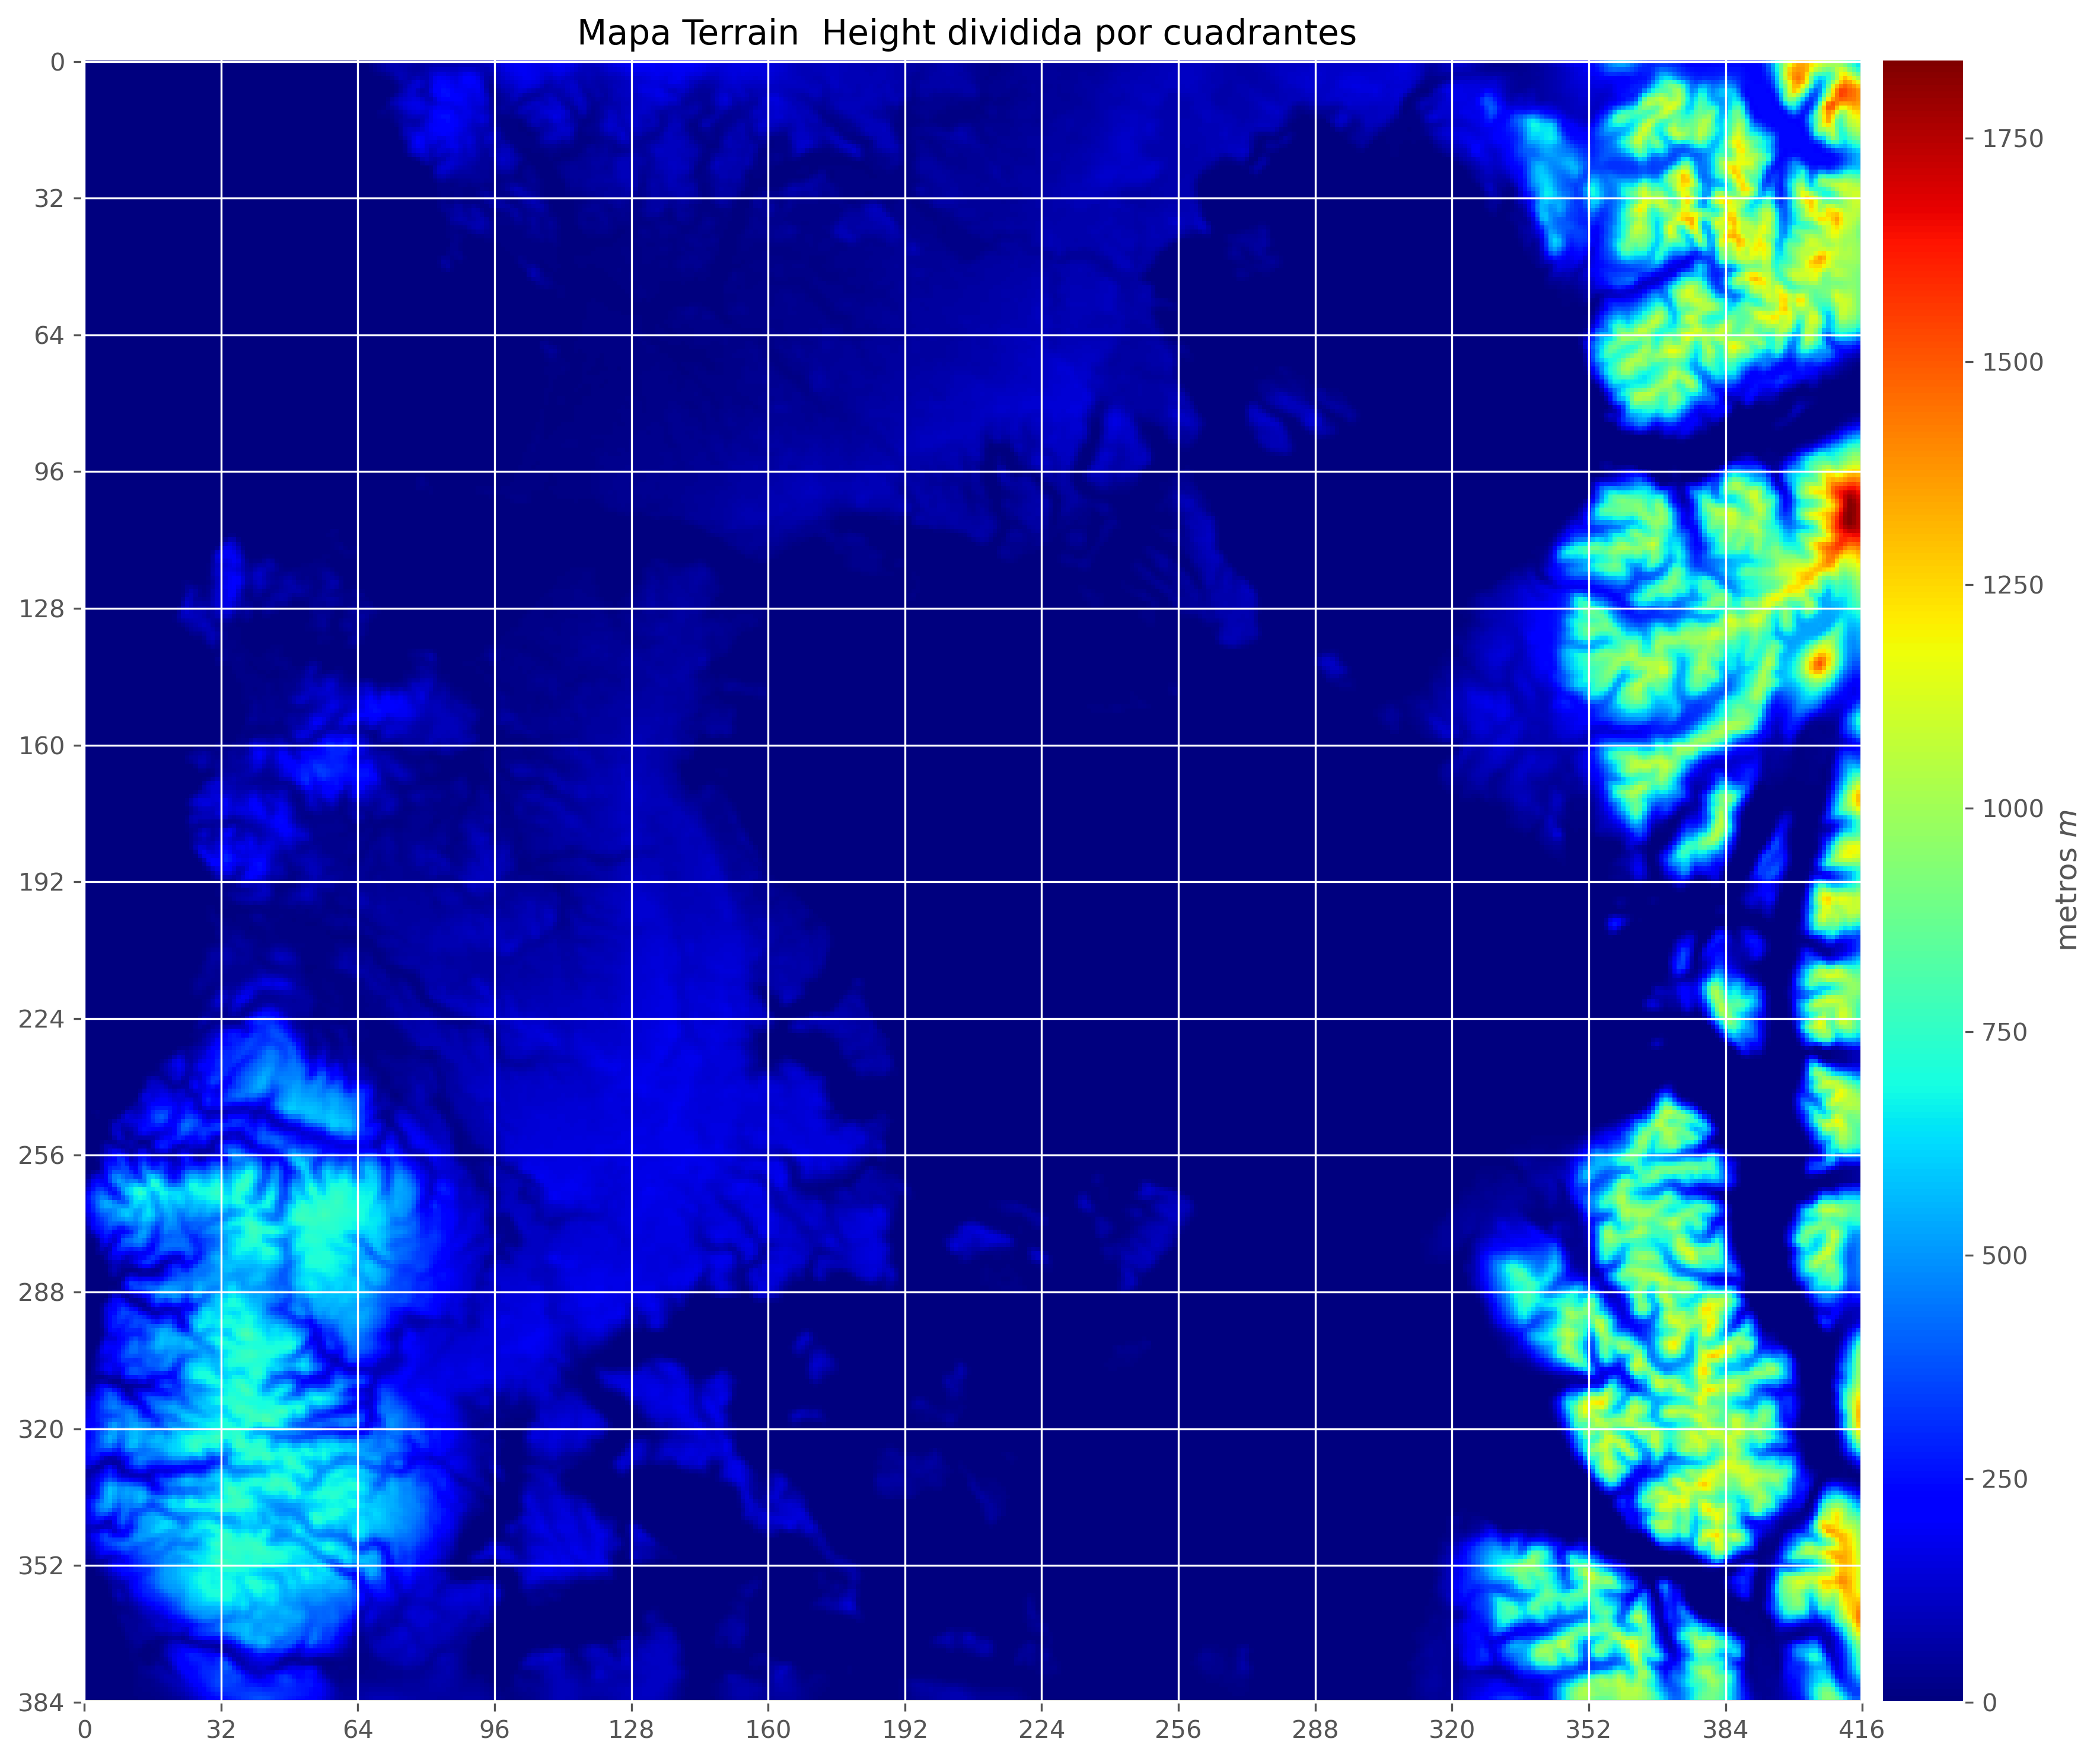

In [35]:
orog_inp    = tf.convert_to_tensor(np.load(f"{path}/raw/hgt_target_raw_190824_16_va.npy"), dtype=tf.float16)

orog_mapa, _, _, _= determinar_inputs(100, orog_inp[:,:,:,0], target_u10, output_u10)


params = {'axes.titlesize': 12,
              'xtick.labelsize':10,
              'ytick.labelsize':10} 
              #'figure.figsize': (50,50),
              #'figure.dpi': 400}
              
plt.style.use('ggplot')
plt.rcParams.update(params)
plt.figure(figsize=(12,10))
plt.imshow(orog_mapa[::-1], vmin = np.min([orog_mapa]), vmax = np.max([orog_mapa]), cmap="jet", interpolation=None)
plt.title('Mapa Terrain  Height dividida por cuadrantes ', fontsize=14)
plt.yticks(np.arange(0, 390, 32))
plt.xticks(np.arange(0, 417, 32))
plt.colorbar(orientation="vertical",fraction=0.047, pad=0.01, label="metros $m$")

plt.tight_layout()
plt.show()